# Calibration Curve for HPLC Analysis

## An example of line fits using error propagation

We have performed a series of injections of a standard solution and seek to create a calibration factor for our analyte. We will also be paying attention to error propagation in my own clumsy way so the errors are properly estimated across all our calculations. In the end, no matter how much I goof up, this notebook will document everything so that others can see exactly what approach I used and correct my work.

We will plot the mean of the peak area for each injection with error bars based on the standard deviation of the measurements. We will then perform a linear fit that includes the standard deviations and obtain a calibration coefficient with its own standard deviation value.

This will provide a rigourous and documented source for the calibration coefficent and its standard deviation.



## Step 1: Load data and calculate means and errors

The code below creates a data frame from the experimental calibration data and adds a column for the mean and stadard deviation across each row.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit

pd.set_option('mode.chained_assignment',None)  ### Supress warnings about "setting with copy" in dataframes


############################
### Set global variables 
############################

#data_path = "https://raw.githubusercontent.com/blinkletter/3530Biochem/main/Permethrin/"
data_path = "./"

image_path = "https://raw.githubusercontent.com/blinkletter/3530Biochem/main/Permethrin/images/"

github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"



################################################################################
### Read data set. The fields are separated by commas; comments are enabled  
################################################################################

df = pd.read_csv(data_path + "R-CIS.csv", 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Vol (/uL)", 
                 comment = "#") 


df_hCE1 = df[["hCE1-1", "hCE1-2", "hCE1-3", "hCE1-4", "hCE1-5"]]
display(df_hCE1)
df_hCE1 = -df_hCE1.subtract(df["C2"], axis='rows')


means = df_hCE1.mean(axis=1)
stdevs = df_hCE1.std(axis=1)

df_hCE1["mean"] = means
df_hCE1["stdev"] = stdevs


df_hCE2 = df[["hCE2-1", "hCE2-2", "hCE2-3", "hCE2-4", "hCE2-5"]]
df_hCE2 = -df_hCE2.subtract(df["C2"], axis='rows')

means = df_hCE2.mean(axis=1)
stdevs = df_hCE2.std(axis=1)

df_hCE2["mean"] = means
df_hCE2["stdev"] = stdevs


### use built-in methods in dataframe to calculate mean and stdev of rows

### Add mean values and st_devs to dataframe for easy comparison.
### display all data in dataframe

display(df_hCE1)
display(df_hCE2)

,hCE1-1,hCE1-2,hCE1-3,hCE1-4,hCE1-5
Vol (/uL),,,,,
2,83056,82598,80201,80349,82359
5,202250,205392,203280,205554,202718
7,285502,284935,285472,286673,288212
10,410406,411186,411183,410082,410073
30,1246612,1246597,1247502,1245127,1245738
50,2087046,2089284,2088981,2090462,2087596
100,4208448,4206585,4205975,4209341,4206374


,hCE1-1,hCE1-2,hCE1-3,hCE1-4,hCE1-5,mean,stdev
Vol (/uL),,,,,,,
2,1494,1952,4349,4201,2191,2837.4,1337.051719
5,12178,9036,11148,8874,11710,10589.2,1536.804867
7,12300,12867,12330,11129,9590,11643.2,1311.563838
10,14542,13762,13765,14866,14875,14362.0,562.581994
30,31516,31531,30626,33001,32390,31812.8,911.177096
50,43383,41145,41448,39967,42833,41755.2,1367.091877
100,54466,56329,56939,53573,56540,55569.4,1466.114354


,hCE2-1,hCE2-2,hCE2-3,hCE2-4,hCE2-5,mean,stdev
Vol (/uL),,,,,,,
2,4244,5090,2257,4546,3135,3854.4,1143.025503
5,9724,13179,11767,13092,11858,11924.0,1397.162661
7,10719,13654,12494,13450,10830,12229.4,1399.016726
10,14409,14853,16099,16232,14891,15296.8,816.692231
30,22904,25172,26580,23995,24651,24660.4,1366.966093
50,29248,29530,28910,29974,29518,29436.0,392.754376
100,31717,33006,35249,35512,35548,34206.4,1748.540048


## Step 2: Perform linear fit with errors

The code below perform a curve fit that includes the errors in each data point (using the standard deviations as the errors). A slope with a standard deviation will be obtained.

I fit the data to the following linear relationship: $$ y = c \cdot x $$ where $y$ is the area, $x$ is the volume injected and $c$ is the correlation coefficient. Observe that this is a linear line passing through the origin. This equation requires that the $y$-intercept is zero by definition.

In [69]:
################################################################################
### Assign arrays of data to x, y, and standard deviations
################################################################################

x = df_hCE1.index
y = df_hCE1["mean"]
stdev = df_hCE1["stdev"]

################################################################################
### Linear curve fit on the collected x,y data
################################################################################

### Create functions that describe linear line fits

def MM_fit(x, Vmax, KM):
    return Vmax*x/(x+KM)


### Perform curve fit using function of choice. Use 'linear' or 'linear0'

param, pcov = curve_fit(MM_fit,              ### use 'linear' or 'linear0'
                        x, y,                ### The day for the fit
                        sigma = stdev,       ### Array of errors for each data point
                        absolute_sigma=True, ### Errors are values, not factors.
                        bounds=([0, 0],[np.inf, np.inf])
                        )

perr = np.sqrt(np.diag(pcov))  ### Calculate st_devs for line fit from covariance matrix


### Use with 'linear0' curve fit. 

Vmax1, KM1 = param             ### param is an array. Vmax is first item and KM is the second.
Vmax1_stdev, KM1_stdev = perr  

#print(f"Line is y = ({slope:0.2f} +/- {slope_stdev:0.2f})x")
print(Vmax1,Vmax1_stdev)
print(KM1,KM1_stdev)



80029.47274682974 3656.402110830378
45.03556771588637 3.743312564659799


## Step 3: Plot data with error pars and line fit

The code below will plot the mean area for the peaks in our six experiments (with error bars) against the injection volume.  The error bars are created using the standard deviations for each mean. A line is plotted using the line fit data.

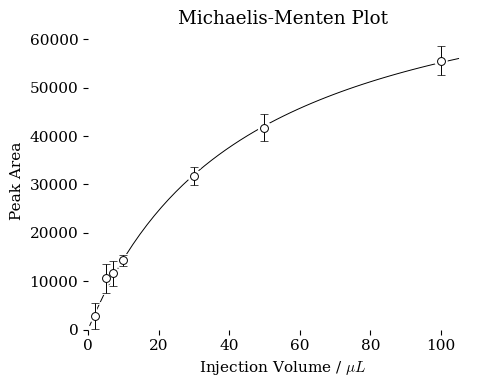

Vmax is (80029.47 +/- 3656.40) Area units/3 hours
KM is (45.04 +/- 3.74) uL injection volume


In [71]:
##################################################
### Setup a figure and choose a style for plot
##################################################

plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

########################
### Plot the data    ###
########################

### Plot data points

ax.scatter(x,y, marker = "o", color = "white", s = 96, edgecolors = "none", linewidths=0.7, zorder = 1)
ax.scatter(x,y, marker = "o", color = "white", s = 32, edgecolors = "black", linewidths=0.7, zorder = 3)


### Add error bars (command could be all on one line as above, but is separated for adding comments)

ax.errorbar(x, y,             ### data
            yerr = 2*stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "white", ### Color of error bars
            elinewidth = 3, ### Thickness of vertical bar
            capsize = 4,      ### width of cap (in points)
            capthick = 2,   ### thickness of cap line
            zorder = 2)
ax.errorbar(x, y,             ### data
            yerr = 2*stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "black", ### Color of error bars
            elinewidth = 0.7, ### Thickness of vertical bar
            capsize = 3,      ### width of cap (in points)
            capthick = 0.5,   ### thickness of cap line
            zorder = 2)


last_x = np.max(df.index)     ### Convert row index into array and choose largest value
x_axis = np.linspace([0.5, last_x * 1.05], 100)  ### Create x-axis for ploting caluclated line fit


### Plot calculated line

ax.plot(x_axis, MM_fit(x_axis, Vmax1, KM1),    ### x, y calculated data for line
        "-", color = "black",      ### solid black line
        linewidth=0.7, zorder = 0  ### line thickness and layer (0 is farthest back)
        )


############################
### Set labels and scale 
############################

ax.set(title = "Michaelis-Menten Plot",
        ylabel=r"Peak Area", 
        xlabel=r"Injection Volume / $\mu L$",
        xlim=0,
        ylim=0
      )

ax.margins(x=.07, y=.07, tight=True)    # add 7% empty space around outside of plot area   

#############################
### Output the final plot 
#############################

fig.savefig("plot_hCE1.pdf")   ### use this to save the figure in PDF format
plt.show()                ### output the combined plot plots

print(f"Vmax is ({Vmax1:0.2f} +/- {Vmax1_stdev:0.2f}) Area units/3 hours")
print(f"KM is ({KM1:0.2f} +/- {KM1_stdev:0.2f}) uL injection volume")



## Do It All Again with hCE2

In [72]:
################################################################################
### Assign arrays of data to x, y, and standard deviations
################################################################################

x = df_hCE2.index
y = df_hCE2["mean"]
stdev = df_hCE2["stdev"]

################################################################################
### Linear curve fit on the collected x,y data
################################################################################

### Create functions that describe linear line fits

def MM_fit(x, Vmax, KM):
    return Vmax*x/(x+KM)


### Perform curve fit using function of choice. Use 'linear' or 'linear0'

param, pcov = curve_fit(MM_fit,              ### use 'linear' or 'linear0'
                        x, y,                ### The day for the fit
                        sigma = stdev,       ### Array of errors for each data point
                        absolute_sigma=True, ### Errors are values, not factors.
                        bounds=([0, 0],[np.inf, np.inf])
                        )

perr = np.sqrt(np.diag(pcov))  ### Calculate st_devs for line fit from covariance matrix


### Use with 'linear0' curve fit. 

Vmax2, KM2 = param             ### param is an array. Vmax is first item and KM is the second.
Vmax2_stdev, KM2_stdev = perr  

print(Vmax2,Vmax2_stdev)
print(KM2,KM2_stdev)


38050.73860446588 1150.6335175859879
14.60764848711826 1.5833434025526185


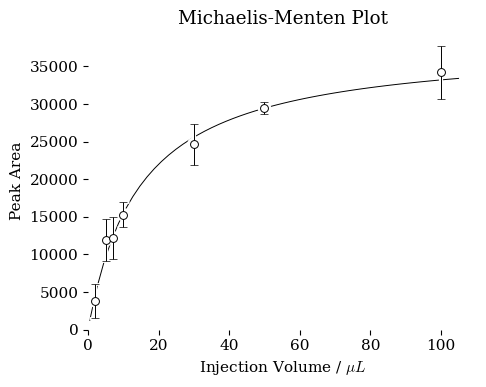

Vmax is (38050.74 +/- 1150.63) Area units/3 hours
KM is (14.61 +/- 1.58) uL injection volume


In [74]:
##################################################
### Setup a figure and choose a style for plot
##################################################

plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

########################
### Plot the data    ###
########################

### Plot data points

ax.scatter(x,y, marker = "o", color = "white", s = 96, edgecolors = "none", linewidths=0.7, zorder = 1)
ax.scatter(x,y, marker = "o", color = "white", s = 32, edgecolors = "black", linewidths=0.7, zorder = 3)


### Add error bars (command could be all on one line as above, but is separated for adding comments)

ax.errorbar(x, y,             ### data
            yerr = 2*stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "white", ### Color of error bars
            elinewidth = 3, ### Thickness of vertical bar
            capsize = 4,      ### width of cap (in points)
            capthick = 2,   ### thickness of cap line
            zorder = 2)
ax.errorbar(x, y,             ### data
            yerr = 2*stdev, ### y errors
            xerr = None,      ### x errors
            fmt = 'None',     ### Data marker style
            ecolor = "black", ### Color of error bars
            elinewidth = 0.7, ### Thickness of vertical bar
            capsize = 3,      ### width of cap (in points)
            capthick = 0.5,   ### thickness of cap line
            zorder = 2)


last_x = np.max(df.index)     ### Convert row index into array and choose largest value
x_axis = np.linspace([0.5, last_x * 1.05], 100)  ### Create x-axis for ploting caluclated line fit


### Plot calculated line

ax.plot(x_axis, MM_fit(x_axis, Vmax2, KM2),    ### x, y calculated data for line
        "-", color = "black",      ### solid black line
        linewidth=0.7, zorder = 0  ### line thickness and layer (0 is farthest back)
        )


############################
### Set labels and scale 
############################

ax.set(title = "Michaelis-Menten Plot",
        ylabel=r"Peak Area", 
        xlabel=r"Injection Volume / $\mu L$",
        xlim=0,
        ylim=0
      )

ax.margins(x=.07, y=.07, tight=True)    # add 7% empty space around outside of plot area   

#############################
### Output the final plot 
#############################

fig.savefig("plot_hCE2.pdf")   ### use this to save the figure in PDF format
plt.show()                ### output the combined plot plots

print(f"Vmax is ({Vmax2:0.2f} +/- {Vmax2_stdev:0.2f}) Area units/3 hours")
print(f"KM is ({KM2:0.2f} +/- {KM2_stdev:0.2f}) uL injection volume")


### Step 4: Convert to preferred units and track errors

The code below will use the *uncertainties* package in the *Python* library to perform calculations with error propagation. We won't have to know how to propagate errors correctly but anyone examining my work will be able to see exactly what I did. 

The *uncertainties* package is not included in the *Python* standard library and so must be installed using the code cell below. Only run this cell once. It wont hurt if you run it again; it just wastes time.

The code cell underneath the install code will import our slope and standard deviation from the line fit and create a ufloat object.  This is a number that includes the uncertainty. Observe the ways I printed it out.

In [94]:
####################################
### Install UNCERTAINTIES package 
####################################

%pip install uncertainties

Note: you may need to restart the kernel to use updated packages.


In [63]:
import uncertainties as un
from uncertainties import unumpy as unp
from uncertainties import umath as um


####################################################################################
### Create calibration coefficient as a floating point number with uncertainty
####################################################################################

coeff = un.ufloat(slope, slope_stdev)

##################################
### Print out the ufloat value
##################################

print(coeff)

print(f"The calibration coefficient is {coeff:0.2f} per microlitre")
print(f"The number is {coeff.n}")
print(f"The st_dev is {coeff.s}")

1635.8+/-2.2
The calibration coefficient is 1635.85+/-2.22 per microlitre
The number is 1635.8472793303606
The st_dev is 2.223118062472124


We now can state the other values. We dont have a population of measurements to determine the standard deviations for these values, we just have "estimated errors" based on experience and manufacturer information.

The automatic sample **injector** is reported to have an accuracy of $\pm 0.1 \, \mu L$

When **weighing** the permethrin sample I used a **balance** with an accuracy of $\pm 0.1 \, mg$

The **pipette** that I used to transfer the solvent for the stock solution has an accuracy of $\pm 0.01 \, mL$

Observe the features of the *uncertanties* package that I used to create these ufloat values.

In [93]:
##################################
### Set values with uncertainties
##################################

volume = un.ufloat_fromstr("2+/-0.01")    ### volume of stock solution is 2 mL; creating ufloat from text
mass = un.ufloat(2,0.1)                   ### mass is 2 mg; creating ufloat from list
molar_mass = 391.29                       ### molar mass of permethrin is 391.29 g/mole; no uncertainty here

##################################
### convert area/uL to area/mole
##################################

### coeff(A/uL) * 1000uL/1mL  * volume/mass(mL/g) * molwt(g/mole) = A/mole

coeff_Area_mole = coeff * 1000 * volume/mass * molar_mass
coeff_Area_mole/1000000

print(f"The correlation coefficient is {coeff_Area_mole/1000000:0.2f} /micromole")

The correlation coefficient is 640.09+/-32.18 /micromole


The error above is about 5%.  That is the error in the mass measurement.  Most of the error was in the precision of the ballance. If I had measured 20mg into 20mL I would have a much better standard deviation for my calibration coefficient. Next time I'll do better. 

The *uncertainties* ufloat data object handled all the rules of propagating error as we multiplied and divided these values. I did not have to keep track but you now know exactly how I propagated the errors --- I delegated it all to the *uncertainties* package. You will be able to repeat my results by following the method as described. And you can now criticize my approach and correct my work, if necessary. 

I will now write this correlation coefficient down in my lab book for future use.

## Summary

The *uncertainties* package is a great calculator that automatically handles errors for us.

In this example we were doing simple math. The *uncertainties* package will handle the propagation of error through log and sin functions and even through derivarions. We only need it for the arithmatic, but it's great to know that it will be there for us when we really need it.
